In [1]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files
import scipy.stats as stats
from scipy.optimize import curve_fit
####新项目，近5年分红去高去低*回购率排名，同时要求分红逆序数（假）不能超过6
# 爬取底层证券的现金及现金等价物，取过去两年，线性回归，计算超过转债赎回价格的概率。
# 先改成用一部分回归然后看整体的mse吧。
# 神经网络 输入价格，转股价值，转债占比，剩余年限，强赎概率，下调转股价条件(redeem_inc_cpn_fl)

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [7]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [13]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,_,_ = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [17]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    raw_data = []
    count = 0
    
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        raw_data.append(dat_cell)
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            #pb
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = dat_cell['bond_nm'] # 转债名称
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
            lst_dat['redeem_price_ratio']  =  dat_cell['redeem_price_ratio']
            lst_dat['redeem_count_days'] =  dat_cell['redeem_count_days']
            lst_dat['redeem_real_days']  =  dat_cell['redeem_real_days']
            
            
            
  
            lst_data.append(lst_dat)
           
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data,raw_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity + 1/365/2  ####fixed dividen 0 problem
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            continue
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio2'] #####ratio is float ratio, ratio is total ratio
        convert_value = float(item['convert_value'])
        
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        #####Adjust convert amt ratio
        convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
        
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        convert_value = float(item['convert_value'])
        force_redeem = item['force_redeem']
        if(force_redeem == "Y"):
            convert_amt_ratio = item['convert_amt_ratio2']#####ratio is float ratio, ratio is total ratio
            convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
            #####Adjust convert amt ratio
            convert_amt_ratio *= convert_value/100  ###adjust the convert amt ratio to the percentage shares
   
            
        else:
            convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        
    
 
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
 
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    db_df = db_df[(db_df['force_redeem'] != 'Y')]
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [30]:
# save raw data

In [31]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [32]:
# plot history

In [33]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [34]:
data,raw_data = get_dat()
pd.DataFrame.from_dict(raw_data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

processing 100 items
processing 200 items
processing 300 items
Finished processing 380 items
successfully save raw CB data


In [35]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 407 lines.


In [36]:
redeem_df = redeem_arbitrage(data)

In [37]:
put_df = put_arbitrage(data)

Finished processing 38 items


110033 国贸转债 not in lists
Sell 110072 广汇转债 94.4 151.270
Sell 113585 寿仙转债 153.27 157.059
Strong Sell 127034 绿茵转债 102.641 166.182
123128 首华转债 not in lists
Strong Sell 128096 奥瑞转债 170.693 176.221
Strong Sell 128127 文科转债 96.241 181.099
Sell 128133 奇正转债 110.652 151.181

Add  128100 搜特转债 100.12 123.821
Add  113009 广汽转债 124.34 129.727
Add  132018 G三峡EB1 126.97 131.563
Add  113607 伟20转债 127.65 135.727
Add  128085 鸿达转债 132.801 136.610
Add  110070 凌钢转债 116.19 138.396
Add  113026 核能转债 128.94 139.434

Buy  113009 广汽转债 124.34 129.727
Buy  110070 凌钢转债 116.19 138.396
Buy  113591 胜达转债 122.9 142.746
Buy  113600 新星转债 129.21 144.636
Buy  128040 华通转债 119.001 144.656
Buy  128106 华统转债 122.046 144.764
Buy  123080 海波转债 122.016 144.787
Buy  128081 海亮转债 123.467 144.956
Buy  128091 新天转债 127.851 145.824
Buy  128076 金轮转债 119.084 145.931
Buy  113541 荣晟转债 135.33 146.143
today coef [2.92001577e-03 7.81538857e-02 9.16609716e+01]
mse=48.802


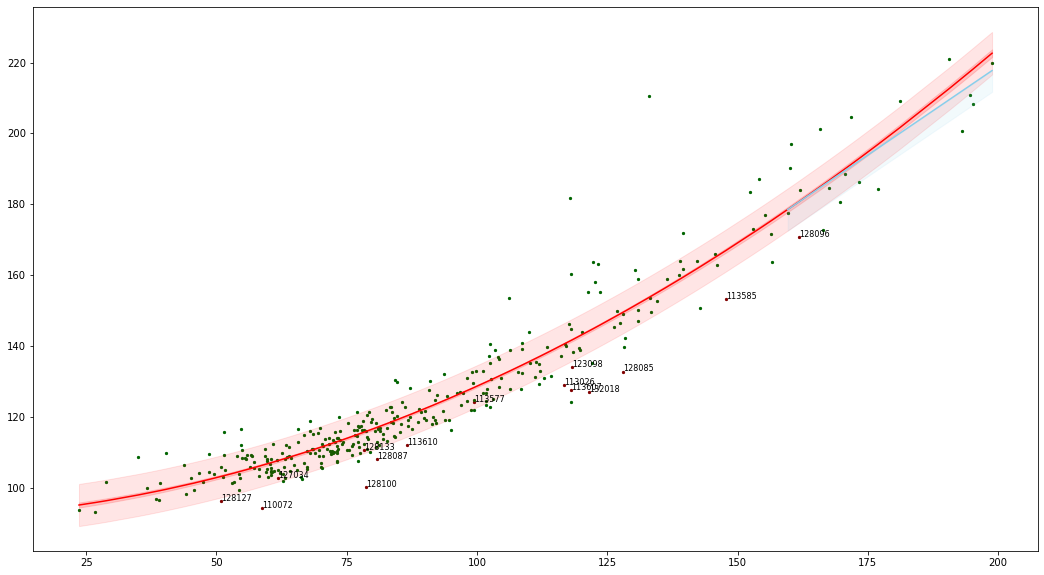

In [38]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [39]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
110066,盛屯转债,193.000304,200.71,3.994655,204.704655,-2.525368,211.904797,205.909985,217.899610
118000,嘉元转债,195.203188,208.22,6.668340,214.888340,0.053168,214.107681,208.109353,220.106010
110048,福能转债,194.543630,210.95,8.433260,219.383260,1.686734,213.448123,207.450855,219.445392
128017,金禾转债,198.825256,219.98,10.639868,230.619868,3.898689,217.729749,211.725482,223.734016
113528,长城转债,181.121121,209.11,15.453128,224.563128,7.761713,200.025614,194.048511,206.002718
123092,天壕转债,190.635491,221.00,15.928046,236.928046,8.573438,209.539984,203.548865,215.531103


In [40]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

110033 国贸转债 not in lists
Sell 113577 春秋转债 124.23 149.267 25.037 1.548
Sell 127034 绿茵转债 102.641 166.182 66.124 0.908
123128 首华转债 not in lists
Sell 128133 奇正转债 110.652 151.181 41.474 0.847

Add  128100 搜特转债 100.12 123.821 27.109 -8.998
Add  113009 广汽转债 124.34 129.727 5.387 -8.311
Add  132018 G三峡EB1 126.97 131.563 4.593 -8.165
Add  128085 鸿达转债 132.801 136.610 3.809 -7.471
Add  110072 广汇转债 94.4 151.270 60.779 -5.972
Add  113607 伟20转债 127.65 135.727 8.077 -5.937

Strong Buy 128100 搜特转债 100.12 123.821 27.109 -8.998
Strong Buy 113009 广汽转债 124.34 129.727 5.387 -8.311
Strong Buy 132018 G三峡EB1 126.97 131.563 4.593 -8.165
Strong Buy 128085 鸿达转债 132.801 136.610 3.809 -7.471
Strong Buy 113607 伟20转债 127.65 135.727 8.077 -5.937
Strong Buy 113026 核能转债 128.94 139.434 10.494 -4.224
Buy 123103 震安转债 172.662 176.425 3.763 -3.842
Buy 132014 18中化EB 150.8 156.355 5.555 -3.636
Buy 113039 嘉泽转债 163.75 168.363 4.613 -3.388
Buy 128128 齐翔转2 184.385 188.639 4.254 -2.850
Strong Buy 110070 凌钢转债 116.19 138.396 22.210 -

In [41]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128100,搜特转债,78.766769,100.120,27.109441,123.821145,-8.997812,115.933274,110.019332,121.847216
113009,广汽转债,117.984335,124.340,5.386872,129.726872,-8.310867,141.529411,135.610400,147.448422
132018,G三峡EB1,121.394009,126.970,4.593300,131.563300,-8.164867,144.179214,138.258633,150.099794
128085,鸿达转债,127.928334,132.801,3.808903,136.609903,-7.470552,149.447049,143.522957,155.371142
110072,广汇转债,58.714284,94.400,60.778593,151.270188,-5.971880,106.316087,100.395498,112.236677
113607,伟20转债,118.110615,127.650,8.076653,135.726653,-5.937244,141.626338,135.707272,147.545404
113585,寿仙转债,147.674724,153.270,3.788919,157.058919,-4.767409,166.881516,160.942802,172.820229
113026,核能转债,116.694318,128.940,10.493812,139.433812,-4.223640,140.544587,134.626123,146.463051
123103,震安转债,166.400811,172.662,3.762715,176.424715,-3.841998,185.518830,179.560720,191.476940


In [42]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,100.120,123.821145
132018,G三峡EB1,126.970,131.563300
113607,伟20转债,127.650,135.726653
128085,鸿达转债,132.801,136.609903
113026,核能转债,128.940,139.433812
113610,灵康转债,111.970,139.903319
128087,孚日转债,108.101,140.948508
123098,一品转债,134.000,147.261187
113577,春秋转债,124.230,149.267109


today quartile 157.98047226505577


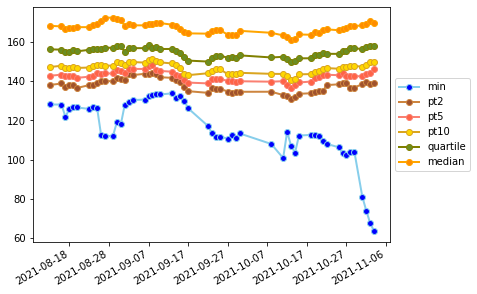

In [43]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 24.60473051781432


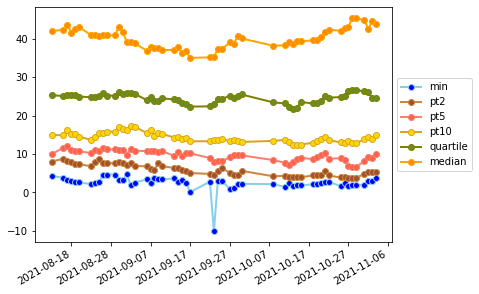

In [44]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 110.0


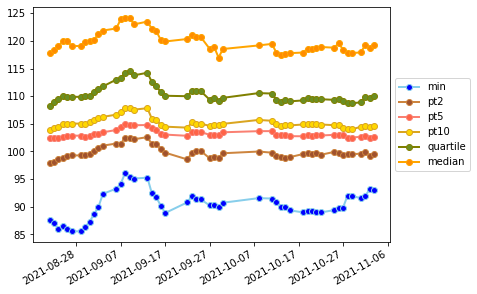

In [45]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [46]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

169.5672443027446
119.191
43.93185732257621


In [47]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113596,城地转债,26.710692,93.110,248.587002,337.738964,3.584755,95.831833,89.887744,101.775923
128062,亚药转债,23.613406,93.794,297.206572,384.037229,5.165042,95.134631,89.187432,101.081831
132011,17浙报EB,28.865023,101.550,251.809872,351.543624,12.324380,96.349812,90.407799,102.291824


In [48]:
def func(X, a, b, c, d):
    x,y = X
    return a * x ** 2 + b * x +  c * y + d 
    #return a* x + b*1/x + c*y +d

In [49]:
def three_factor_arbitrage(db_df): 
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    
    redeem_default_prob = 0.5    #####probility of force redeem if conditons is satisfied
    time_decay_factor = 0.25  ######hyper parameter simulated time decay 
    redeem_default_days = 20 ####20 days to be forced redeem
    
    regression_data = []
    for cb_id,row in db_df.iterrows():
        name = row['name']
        price = row['price']
        value = row['new_convert_value']
        premium = row['new_premium']
        db_low = row['db_low']
        force_redeem = row['force_redeem']
        convert_value       = float(row['convert_value'])
        redeem_price_ratio  = float(row['redeem_price_ratio'])
        redeem_count_days   = int(row['redeem_count_days'])
        redeem_real_days    = int(row['redeem_real_days'])
        
        today = date.today()
        time_to_exp = 0
        expire_dt = today
        time_to_redeem = 0
        redeem_prob = 1
        if(force_redeem == 'Y'):
            redeem_dt    = row['redeem_dt']
            expire_dt = redeem_dt     
            if(redeem_dt == None):
                time_to_redeem = redeem_default_days/365 
            else:
                redeem_dt = datetime.strptime(redeem_dt,'%Y-%m-%d').date()
                days_interval = redeem_dt-today
                time_to_redeem = days_interval.days/365
            time_to_exp = time_to_redeem
        else:
            maturity_dt  = row['maturity_dt']
            expire_dt = maturity_dt
            maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
            days_interval = maturity_dt-today
            time_to_exp = days_interval.days/365
            redeem_prob = 0
            if(force_redeem == 'X' and convert_value >= redeem_price_ratio):
                days_to_satisfied = redeem_count_days-redeem_real_days if redeem_count_days>redeem_real_days  else 0
                days_to_satisfied += redeem_default_days
                time_to_redeem = days_to_satisfied/365
                redeem_prob = redeem_default_prob*redeem_real_days/redeem_count_days if redeem_count_days>redeem_real_days else redeem_default_prob
                #print("可能强赎:%s,%s,%s,%s,%d,redeem_prob:%.3f"%(cb_id,name,convert_value,price,redeem_real_days,redeem_prob))
                
        time_value = (1-redeem_prob) * time_to_exp ** time_decay_factor + redeem_prob * time_to_redeem ** time_decay_factor
            
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            #print("妖债:%s,%s,%s,%s"%(cb_id,name,convert_value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        regression_data.append({'id':cb_id,'name':name,'db_low':db_low,'value':value,'price':price,'time':time_to_exp,
                                'expire':expire_dt,'time_value':time_value,'redeem_prob':redeem_prob})

    
    regression_df = pd.DataFrame(regression_data)
    regression_df = regression_df.set_index(['id'])
    #y_df.sort_values('deviation',ascending=True)
    
    x  = regression_df['value']
    y  = regression_df['time_value']
    z = regression_df['price']
    
    popt, pcov = curve_fit(func,(x,y),z)
    print(popt)
    limit_value = (1-popt[1])/2/popt[0]
    intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
    print(limit_value)
    zfit = func((x,y), *popt)

    n = len(x)
    resid = z - zfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)

    td_data = []
    se = 0
    for cb_id,row in regression_df.iterrows():
        cb_name = row['name']
        db_low  = row['db_low']
        value      = row['value']
        time_to_exp = row['time']
        expire_dt  = row['expire']
        time_value = row['time_value']
        price = row['price']
        premium = price/value-1
        fit_price = func((value,time_value), *popt)
        
                     
        origin_time_value = time_to_exp ** time_decay_factor
        origin_fit_price = func((value,origin_time_value), *popt)
        
        if(value>limit_value):
            fit_price = value+intercept + popt[2] * time_value + popt[3]
            origin_fit_price = value+intercept + popt[2] * origin_time_value + popt[3]
         
           ####set minimum fit price
        minimum_fit_price = origin_fit_price/(1+premium)
        if(fit_price < minimum_fit_price):
            fit_price = minimum_fit_price
        
        se += (fit_price-price)**2
        deviation = price/(fit_price)*100-100
        item = {'id':cb_id,'name':cb_name,'value': value,'time_to_exp':time_to_exp,'price':price,
                'premium':premium,'db_low':db_low, 'deviation':deviation,
                'fit_price':fit_price,'ori_fit_price':origin_fit_price,'min_fit_price':minimum_fit_price,'expire_dt':expire_dt,'redeem_prob':row['redeem_prob']}
        td_data.append(item)
            

    td_df = pd.DataFrame(td_data)
    td_df = td_df.set_index(['id'])
    td_df = td_df.sort_values('deviation')
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    mse2 = se/n
    print("adjuse mse=%.3f"%mse2)
    return popt,td_df

In [50]:
def buy_sell_three(td_df,file,show_price=False):
    total_number = len(td_df)
    quartile = np.percentile(td_df['deviation'],25) ##first quartile
    tenthtile = np.percentile(td_df['deviation'],10) ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    buy_dict = {i:td_df['name'][i] for i in td_df[0:buy_number].index}
    add_dict = {i:td_df['name'][i] for i in td_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,position1,position2 = row
            if cb_id not in td_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = td_df.loc[cb_id]['price']
            value = td_df.loc[cb_id]['value']
            time_to_exp  = td_df.loc[cb_id]['time_to_exp']
            premium = td_df.loc[cb_id]['premium']
            deviation = td_df.loc[cb_id]['deviation']
            fit_price = td_df.loc[cb_id]['fit_price']
            expire_dt = td_df.loc[cb_id]['expire_dt']
            redeem_prob = td_df.loc[cb_id]['redeem_prob']
            item = {'id':cb_id,'name':cb_name,'time_to_exp':time_to_exp,'value':value,'price':price,'premium':premium,
                'deviation':deviation,'expire_dt':expire_dt,'redeem_prob':redeem_prob,'position1':position1,'positon2':position2}
            my_list.append(item)
            if deviation > tenthtile:
                sell = "Sell"
                if(deviation>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                          %(sell,cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                  %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = td_df.loc[cb_id]['price']
        time_to_exp  = td_df.loc[cb_id]['time_to_exp']
        premium = td_df.loc[cb_id]['premium']
        deviation = td_df.loc[cb_id]['deviation']
        redeem_prob = td_df.loc[cb_id]['redeem_prob']
        if cb_id not in holding_dict.keys():
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
        else:
            print("Have %s %s %s %.3f %.3f %.3f,redeem_prob:%.2f"
                      %(cb_id,cb_name,time_to_exp,price,premium,deviation,redeem_prob))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('deviation',ascending=True)
    return my_df
    

In [51]:
#110048	福能转债 ! 10月6日前不提前赎回
popt,td_df = three_factor_arbitrage(db_df)

[2.96997987e-03 6.36877514e-02 9.26572825e+00 7.93671778e+01]
157.62939284371637
mse=50.842
adjuse mse=50.322


In [52]:
 buy_sell_three(td_df,'mycb_list.csv',show_price=True)

Sell 113577 春秋转债 4.443835616438356 124.230 0.250 -3.297,redeem_prob:0.00
123128 首华转债 not in lists
Sell 128133 奇正转债 4.884931506849315 110.652 0.415 -4.850,redeem_prob:0.00

Add  128100 搜特转债 4.353424657534247 100.120 0.271 -13.834,redeem_prob:0.00
Add  110033 国贸转债 0.0027397260273972603 101.860 0.015 -13.535,redeem_prob:1.00
Add  110072 广汇转债 4.789041095890411 94.400 0.608 -11.819,redeem_prob:0.00
Add  113607 伟20转债 4.997260273972603 127.650 0.081 -10.216,redeem_prob:0.00
Add  132018 G三峡EB1 2.4328767123287673 126.970 0.046 -8.584,redeem_prob:0.50
Add  128085 鸿达转债 4.120547945205479 132.801 0.038 -8.389,redeem_prob:0.50

Have 128100 搜特转债 4.353424657534247 100.120 0.271 -13.834,redeem_prob:0.00
Have 110033 国贸转债 0.0027397260273972603 101.860 0.015 -13.535,redeem_prob:1.00
Have 110072 广汇转债 4.789041095890411 94.400 0.608 -11.819,redeem_prob:0.00
Have 113607 伟20转债 4.997260273972603 127.650 0.081 -10.216,redeem_prob:0.00
Have 132018 G三峡EB1 2.4328767123287673 126.970 0.046 -8.584,redeem_prob:0.50
Ha

,name,time_to_exp,value,price,premium,deviation,expire_dt,redeem_prob,position1,positon2
id,,,,,,,,,,
128100,搜特转债,4.353425,78.766769,100.120,0.271094,-13.833805,2026-03-11,0.0,20,20
110033,国贸转债,0.002740,100.377425,101.860,0.014770,-13.534534,2021-11-04,1.0,10,0
110072,广汇转债,4.789041,58.714284,94.400,0.607786,-11.818677,2026-08-17,0.0,30,0
113607,伟20转债,4.997260,118.110615,127.650,0.080767,-10.215994,2026-11-01,0.0,20,0
132018,G三峡EB1,2.432877,121.394009,126.970,0.045933,-8.584375,2024-04-09,0.5,30,0
128085,鸿达转债,4.120548,127.928334,132.801,0.038089,-8.389393,2025-12-16,0.5,20,10
113585,寿仙转债,4.597260,147.674724,153.270,0.037889,-8.281250,2026-06-08,0.0,20,0
113026,核能转债,3.446575,116.694318,128.940,0.104938,-7.813032,2025-04-14,0.0,10,0
128087,孚日转债,4.123288,80.884852,108.101,0.336480,-7.726467,2025-12-17,0.0,20,20


In [53]:
td_df[0:20]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,
128100,搜特转债,78.766769,4.353425,100.120,0.271094,123.821145,-13.833805,116.194060,116.194060,91.412611,2026-03-11,0.0
110033,国贸转债,100.377425,0.002740,101.860,0.014770,63.341061,-13.534534,117.804257,117.804257,116.089612,2021-11-04,1.0
110072,广汇转债,58.714284,4.789041,94.400,0.607786,151.270188,-11.818677,107.052147,107.052147,66.583582,2026-08-17,0.0
113607,伟20转债,118.110615,4.997260,127.650,0.080767,135.726653,-10.215994,142.174542,142.174542,131.549727,2026-11-01,0.0
132018,G三峡EB1,121.394009,2.432877,126.970,0.045933,131.563300,-8.584375,138.893104,142.437645,136.182380,2024-04-09,0.5
128085,鸿达转债,127.928334,4.120548,132.801,0.038089,136.609903,-8.389393,144.962471,149.321671,143.842837,2025-12-16,0.5
113585,寿仙转债,147.674724,4.597260,153.270,0.037889,157.058919,-8.281250,167.108689,167.108689,161.008218,2026-06-08,0.0
113026,核能转债,116.694318,3.446575,128.940,0.104938,139.433812,-7.813032,139.867925,139.867925,126.584397,2025-04-14,0.0
128087,孚日转债,80.884852,4.123288,108.101,0.336480,140.948508,-7.726467,117.152770,117.152770,87.657694,2025-12-17,0.0


In [54]:
td_df.loc['123111']

name                   东财转3
value            130.790801
time_to_exp        5.424658
price               146.999
premium            0.123925
db_low           159.391461
deviation         -3.697438
fit_price        152.642876
ori_fit_price    152.642876
min_fit_price     135.81238
expire_dt        2027-04-06
redeem_prob             0.0
Name: 123111, dtype: object

In [55]:
db_df.loc['123111']

name                        东财转3
stock_id               300059.sz
stock_name                  东方财富
price                    146.999
convert_value             138.97
premium_rt                 5.78%
rating_cd                    AA+
pb                          8.18
convert_amt_ratio           5.5%
convert_amt_ratio2          4.5%
next_put_dt           2025-04-07
put_price                100.000
put_convert_price          16.34
maturity_dt           2027-04-06
redeem_price             107.000
last_time                  5.425
force_redeem                   N
redeem_dt                   None
force_redeem_price         30.36
redeem_price_ratio       130.000
redeem_count_days             15
redeem_real_days              16
redeem_CAGR                  0.0
put_CAGR                     0.0
new_convert_value     130.790801
new_premium             0.123925
db_low                159.391461
Name: 123111, dtype: object

In [56]:
td_df[(td_df['time_to_exp']<0)]

,name,value,time_to_exp,price,premium,db_low,deviation,fit_price,ori_fit_price,min_fit_price,expire_dt,redeem_prob
id,,,,,,,,,,,,


In [57]:
value = 137.04*0.94
year = 0.03
limit_value = 154.03443402217655
intercept = popt[0] * limit_value**2 + popt[1]* limit_value - limit_value
time_value = year**0.25
func((value,time_value),*popt)
#value+intercept + popt[2] * time_value + popt[3]

140.71125300025713

In [58]:
147*0.943

138.62099999999998

In [59]:
137.39/145

0.9475172413793103

In [60]:
140+151

291

In [61]:
130/138

0.9420289855072463

In [62]:
137*0.94

128.78